In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

0.35714285714285715

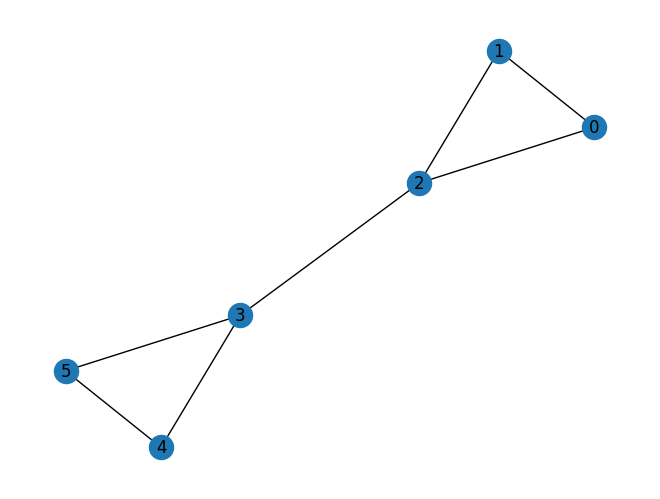

In [2]:
G = nx.barbell_graph(3, 0)
nx.draw(G, with_labels = True)
nx.community.modularity(G, nx.community.label_propagation_communities(G))

Changing the Spearman p-values based on modularity won't affect the differential networks, since we only look at the Spearman correlation coefficients for the permutations. I think it only changes the network visualisation step, as well as the visualisation for the integrated stage.

### Testing modularity for networks with all samples included:

In [3]:
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered.gml")
metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered.gml")

KeyboardInterrupt: 

In [4]:
proteomic = nx.read_gml("Cytoscape/proteomic_prefiltered_commoncases.gml")
metabolomic = nx.read_gml("Cytoscape/metabolomic_prefiltered_commoncases.gml")

In [ ]:
metabolomic.edges(data=True)

### Testing modularity on fully connected graph

In [5]:
#https://sites.google.com/view/paztronomer/blog/basic/python-colors
#goes up to 15 colours
color_scheme = ["skyblue","orange","green","purple","midnightblue","red","pink","yellow","brown","magenta","cyan","salmon","lime","orchid","khaki"]

def supply_colours (network_copy,clusters):
    color_map = []
    for node in network_copy:
        for index in range(len(clusters)):
            try:
                if node in clusters[index]:
                    color_map.append(color_scheme[index])
            except IndexError:
                    color_map.append("grey")   #colours the first fifteen colours, after that colours the rest grey
    return(color_map)

In [ ]:
G = proteomic.copy()

#Removing edges with high overlap:
#edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Overlap_coef'] >= 0.5]
#G.remove_edges_from(edges_to_remove)

#len(edges_to_remove)

In [ ]:
clusters = nx.community.louvain_communities(G,weight='Squared_corr',seed=100,resolution=1.05)
print(len(clusters))

In [ ]:
color_map = supply_colours(G,clusters)
squared_corr = [i['Squared_corr'] for i in dict(G.edges).values()] #Sara's code, used to vary edge weight

nx.draw(G, node_size = 10,node_color=color_map,pos=nx.spring_layout(G,weight="Squared_corr",seed=100), with_labels=False,width= squared_corr)  #,edge_color=squared_corr,edge_cmap=plt.cm.Blues

In [ ]:
#Does not work with a fully connected graph...
nx.community.modularity(G,communities = clusters)

#...unless you supply the weights
nx.community.modularity(G, communities = clusters,weight="Squared_corr")
                        

### Filtering by Spearman p-value

Before I was using nx.community.label_propagation_communities but it doesn't give the options to provide weights so I switched to Louvain instead

['R-HSA-209776', 'R-HSA-422085', 'R-HSA-9020933']
7
85187


0.13663711120058863

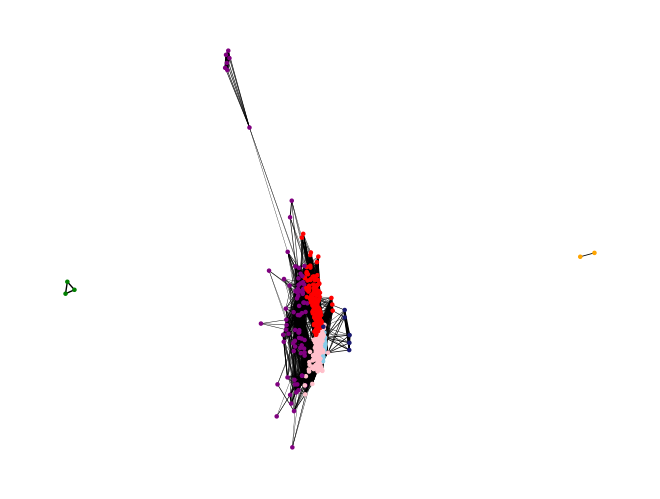

In [6]:
#Example code: Testing modularity 

G = proteomic.copy()
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Spearman_pval'] >= 0.005]
G.remove_edges_from(edges_to_remove)

nodes_to_remove = list(nx.isolates(G))
print(nodes_to_remove)
G.remove_nodes_from(nodes_to_remove)

#nx.community.modularity(G, nx.community.label_propagation_communities(G))
clusters = nx.community.louvain_communities(G,weight='Squared_corr',seed=100,resolution=1)
print(len(clusters))

color_map = supply_colours(G,clusters)
squared_corr = [i['Squared_corr'] for i in dict(G.edges).values()] #Sara's code



nx.draw(G, node_size = 5,node_color=color_map,pos=nx.spring_layout(G,weight="Squared_corr",seed=100), with_labels=False,width= squared_corr)
print(G.number_of_edges())

nx.community.modularity(G, communities = clusters,weight="Squared_corr")

In [7]:
def modularity_test(omics_type,val):
    G =  omics_type.copy()
    edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Spearman_pval'] >= val]
    G.remove_edges_from(edges_to_remove)
    #print(len(edges_to_remove))

    edges_left = G.number_of_edges()

    clusters = nx.community.louvain_communities(G,weight='Squared_corr',seed=100,resolution=1)
    num_clusters = len(clusters)

    modularity = round(nx.community.modularity(G, communities = clusters,weight="Squared_corr"),2)

    return (modularity,edges_left,num_clusters)

In [ ]:
print(modularity_test(metabolomic,0.005))
print(modularity_test(proteomic,0.005))

In [ ]:
x = np.logspace(-100,0, num=25, base=10)  
print(x)

for val in x:
    print(val)
    print(modularity_test(metabolomic,val))

In [ ]:
modularity_test(metabolomic,0.005)   #0.0062

### Scatterplot for omics networks with whole dataset (samples unfiltered regardless of lack of overlap)

In [ ]:
x = np.logspace(-100, 0, num=50) 
proteomic_modularity = []
proteomic_edge = []

metabolomic_modularity = []
metabolomic_edge = []

for val in x:
    proteomic_modularity.append(modularity_test(proteomic,val)[0])
    proteomic_edge.append(modularity_test(proteomic,val)[1])

    metabolomic_modularity.append(modularity_test(metabolomic,val)[0])
    metabolomic_edge.append(modularity_test(metabolomic,val)[1])


In [ ]:
log_x = -np.log10(x)

In [ ]:

pval_df = pd.DataFrame({'proteomic' : proteomic_modularity, 'metabolomic': metabolomic_modularity})
pval_df.index = log_x
pval_df_long = pval_df.stack().reset_index()
pval_df_long = pval_df_long.rename(columns={'level_0': 'Spearman log p-value', 'level_1': 'omics type', 0 : 'modularity'})


pval_df_long

In [ ]:
pro_list = list(proteomic_edge[::5])
pro_list.reverse()

met_list = list(metabolomic_edge[::5])
met_list.reverse()


#Create labels for the rows and columns as tuples
rowLabels = ['proteomic', 'metabolomic']
table_data = [pro_list,met_list]

sns.lineplot(pval_df_long,x = "Spearman log p-value", y = "modularity",  hue = "omics type")      

#plt.title('Comparison of omics modularity with whole dataset',fontsize=16)
plt.title('Comparison of omics modularity for common cases',fontsize=16)
plt.xlabel("Spearman p-values (-log10)",fontsize=13, labelpad=5)
plt.ylabel("Modularity",fontsize=13, labelpad=10) 

plt.axvline(x=-np.log10(0.005), color='red', linewidth=0.8, linestyle='--', dashes=(8, 5))
plt.text(3.2, 0.79, "p-val = 0.005",fontsize=10)

#Approximate p-value where the two lines cross
#plt.axvline(x=-np.log10(0.28e-25), color='black', linewidth=0.5, linestyle='--', dashes=(8, 5))
#plt.text(21, 0.65, "p-val = 0.28e-25",fontsize=10)


plt.text(15, -0.1, "Number of edges remaining",fontsize=16)

#Show the table underneath the figure
table = plt.table(cellText=table_data,
                  rowLabels=rowLabels,
                  loc='bottom',
                  bbox=[0.05, -0.5, 0.9, 0.2], #specify where 
                  cellLoc = "center")

table.auto_set_font_size(False)
table.set_fontsize(8.5)

#plt.savefig('Figures/modularity_all.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
plt.savefig('Figures/modularity_commoncases.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')


### Visualising networks and Louvain communities


['R-HSA-209776', 'R-HSA-422085', 'R-HSA-9020933']
7
85187


0.13663711120058863

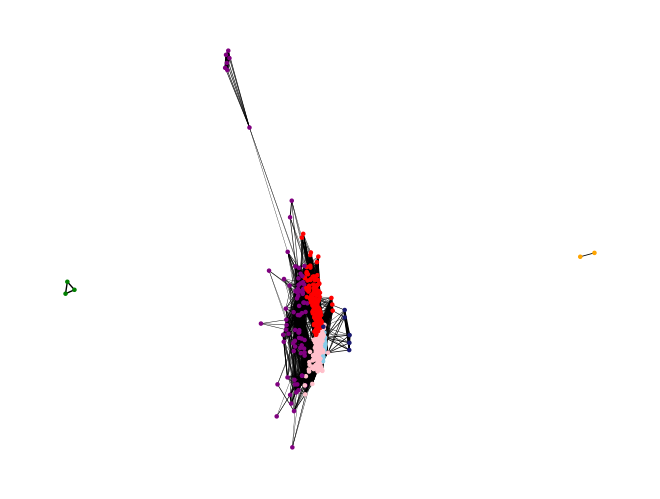

In [12]:
#plt.figure(figsize=(20,10))

G = proteomic.copy()
edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Spearman_pval'] >= 0.005]
G.remove_edges_from(edges_to_remove)

nodes_to_remove = list(nx.isolates(G))
print(nodes_to_remove)
G.remove_nodes_from(nodes_to_remove)

#nx.community.modularity(G, nx.community.label_propagation_communities(G))
clusters = nx.community.louvain_communities(G,weight='Squared_corr',seed=100,resolution=1)
print(len(clusters))

color_map = supply_colours(G,clusters)
squared_corr = [i['Squared_corr'] for i in dict(G.edges).values()] #Sara's code



nx.draw(G, node_size = 5,node_color=color_map,pos=nx.spring_layout(G,weight="Squared_corr",seed=100), with_labels=False,width= squared_corr)
print(G.number_of_edges())

nx.community.modularity(G, communities = clusters,weight="Squared_corr")

### Filtering by overlap coefficient

In [ ]:
def modularity_test(omics_type,val):
    G =  omics_type.copy()
    edges_to_remove = [(u,v) for u,v,e in G.edges(data=True) if e['Overlap_coef'] >= val]
    G.remove_edges_from(edges_to_remove)
    #print(len(edges_to_remove))

    edges_left = G.number_of_edges()

    clusters = nx.community.louvain_communities(G,weight='Squared_corr',seed=100,resolution=1)
    num_clusters = len(clusters)

    modularity = round(nx.community.modularity(G, communities = clusters,weight="Squared_corr"),2)

    return (modularity,edges_left,num_clusters)

In [ ]:
metabolomic.edges(data=True)
modularity_test(metabolomic,0.1)

In [ ]:
#x = np.linspace(0.1, 1, num=18) 
x = np.arange(0.1, 1.05, 0.05)

proteomic_modularity = []
proteomic_edge = []

metabolomic_modularity = []
metabolomic_edge = []

for val in x:
    proteomic_modularity.append(modularity_test(proteomic,val)[0])
    proteomic_edge.append(modularity_test(proteomic,val)[1])

    metabolomic_modularity.append(modularity_test(metabolomic,val)[0])
    metabolomic_edge.append(modularity_test(metabolomic,val)[1])


In [ ]:
oc_df = pd.DataFrame({'proteomic' : proteomic_modularity, 'metabolomic': metabolomic_modularity})
oc_df.index = x
oc_df_long = oc_df.stack().reset_index()
oc_df_long = oc_df_long.rename(columns={'level_0': 'Overlap coef', 'level_1': 'omics type', 0 : 'modularity'})

In [ ]:
x

In [ ]:
pro_list = list(proteomic_edge[::2])
met_list = list(metabolomic_edge[::2])

#Create labels for the rows and columns as tuples
rowLabels = ['proteomic', 'metabolomic']
colLabels = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
table_data = [pro_list,met_list]


sns.lineplot(oc_df_long,x = "Overlap coef", y = "modularity",  hue = "omics type")      

#plt.title('Comparison of omics modularity with whole dataset',fontsize=16)
#plt.title('Comparison of omics modularity for common cases',fontsize=16)
plt.xlabel("Overlap coefficient",fontsize=13, labelpad=5)
plt.ylabel("Modularity",fontsize=13, labelpad=10) 
plt.xticks(np.arange(min(x), max(x)+0.05, 0.1)) 

plt.axvline(x=0.5, color='red', linewidth=0.8, linestyle='--', dashes=(8, 5))
plt.text(0.53, 0.28, "overlap = 0.5",fontsize=10)

plt.text(0.21, 0.035, "Number of edges remaining",fontsize=16)

#Show the table underneath the figure
table = plt.table(cellText=table_data,
                  rowLabels=rowLabels,
                  colLabels=colLabels,
                  loc='bottom',
                  bbox=[0.05, -0.5, 0.9, 0.2], #specify where 
                  cellLoc = "center")

table.auto_set_font_size(False)
table.set_fontsize(7)

#plt.savefig('Figures/modularity_all_oc.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
#plt.savefig('Figures/modularity_commoncases_oc.png' ,dpi=200,bbox_inches = 'tight' , pad_inches = 0.2 , facecolor='w')
